## Chapter5 EM 알고리즘

In [1]:
import os
import numpy as np

path = "./old_faithful.txt"
xs = np.loadtxt(path)

phis = np.array([.5, .5])
mus = np.array([[2, 50.0], [4, 100.0]])
covs = np.array([np.eye(2), np.eye(2)])

In [2]:
K = len(phis) # number of Gaussians
N = len(xs) # number of data points
MAX_ITER = 100 # maximum number of iterations of EM Algorithm
THRESHOLD = 1e-6 # convergence threshold of EM Algorithm

#### 필요한 함수들 정의

In [3]:
def multivariate_normal(x, mu, cov):
    det = np.linalg.det(cov)
    inv = np.linalg.inv(cov)
    d = len(x)
    z = 1 / np.sqrt((2 * np.pi) ** d * det)
    return z * np.exp(-.5 * (x - mu).T @ inv @ (x - mu))

def gmm(x, phis, mus, covs):
    K = len(phis)
    y = 0
    for k in range(K):
        phi, mu, cov = phis[k], mus[k], covs[k]
        y += phi * multivariate_normal(x, mu, cov)
    return y

def liklihood(xs, phis, mus, covs):
    eps = 1e-8
    L = 0
    N = len(xs)
    for x in xs:
        y = gmm(x, phis, mus, covs)
        L += np.log(y + eps)
    return L / N

#### 각 함수에 대한 Reviews

**1. MultiVariate Normal**

$$ x = [x_1, x_2, \dots, x_D]^T $$

$$ N(x; \mu, \Sigma) = \frac{1}{\sqrt{(2 \pi)^D |\Sigma|}} \exp \left( -\frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu) \right) $$

- 평균 벡터: $ \mu $
- 공분산 행렬: $ \Sigma $

**2. GMM**
- $ \phi _{k} $ 는 각 K개 중에 몇번째 가우스 분포에 속하는지 선택할 확률 분포임. 기억 나시죠?
$$ p(x) = \sum_{k=1}^{K} \phi _{k} N(x;\mu _{k},\Sigma _{k}) $$

### EM 알고리즘 구현

In [4]:
current_liklihood = liklihood(xs, phis, mus, covs)

for iter in range(MAX_ITER):
    qs = np.zeros((N, K))
    # >> E-STEP
    for n in range(N):
        x = xs[n]
        for k in range(K):
            phi, mu, cov = phis[k], mus[k], covs[k]
            qs[n, k] = phi * multivariate_normal(x, mu, cov)
        qs[n] /= np.sum(qs[n])
    
    # >> M-STEP

    qs_sum = np.sum(qs, axis=0)
    for k in range(K):
        # 1. phis
        phis[k] = qs_sum[k] / N

        # 2. mus
        c = 0
        for n in range(N):
            c += qs[n, k] * xs[n]
        mus[k] = c / qs_sum[k]

        # 3. covs
        c = 0
        for n in range(N):
            z = xs[n] - mus[k]
            z = z[:, np.newaxis]
            c += qs[n, k] * z @ z.T
        covs[k] = c / qs_sum[k]

    # >> Convergence Check
    print(f"Iteration {iter}: Liklihood = {current_liklihood:.4f}")
    next_liklihood = liklihood(xs, phis, mus, covs)
    diff = np.abs(next_liklihood - current_liklihood)
    if diff < THRESHOLD:
        break
    current_liklihood = next_liklihood

Iteration 0: Liklihood = -16.0952
Iteration 1: Liklihood = -4.4002
Iteration 2: Liklihood = -4.3402
Iteration 3: Liklihood = -4.2826
Iteration 4: Liklihood = -4.2284
Iteration 5: Liklihood = -4.1864
Iteration 6: Liklihood = -4.1588
Iteration 7: Liklihood = -4.1555
Iteration 8: Liklihood = -4.1554
Iteration 9: Liklihood = -4.1554


### Visualization

- 2개의 Image를 생성한다. 첫번째는 원분포, 두번째는 GMM으로 형성된 model에 대한 분포이다.

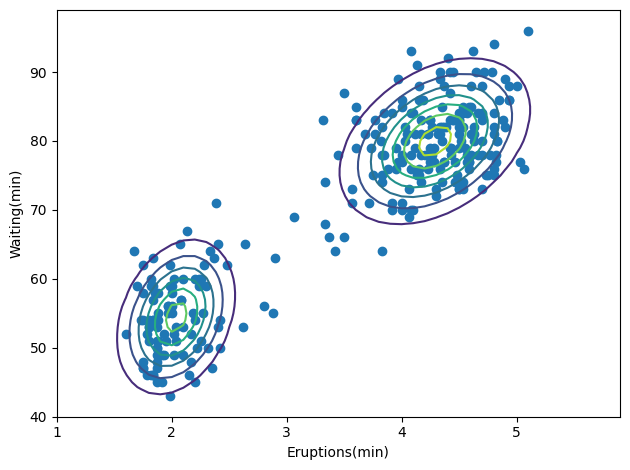

In [11]:
import matplotlib.pyplot as plt

def plot_contour(w, mus, covs):
    x = np.arange(1, 6, 0.1)
    y = np.arange(40, 100, 1)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            x = np.array([X[i, j], Y[i, j]])

            for k in range(len(mus)):
                mu, cov = mus[k], covs[k]
                Z[i, j] += w[k] * multivariate_normal(x, mu, cov)
    plt.contour(X, Y, Z)

plt.clf()
plt.plot(xs[:, 0], xs[:, 1], 'o')
plot_contour(phis, mus, covs)
plt.ylabel("Waiting(min)")
plt.xlabel("Eruptions(min)")
plt.tight_layout()
plt.savefig("./result_images/gmm-original.png")
plt.show()

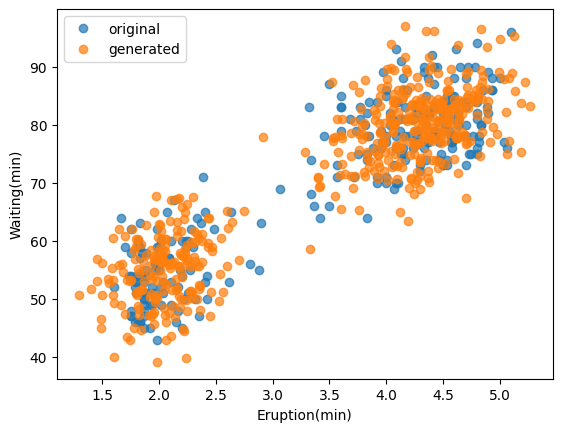

In [ ]:
# > Original Data
plt.clf()
plt.plot(xs[:, 0], xs[:, 1], 'o', label='original', alpha=.7)

# > Generated Data
N = 500
new_xs = np.zeros((N, 2))
for n in range(N):
    k = np.random.choice(K, p=phis)
    mu, cov = mus[k], covs[k]
    new_xs[n] = np.random.multivariate_normal(mu, cov)

plt.plot(new_xs[:, 0], new_xs[:, 1], 'o', label='generated', alpha=.7)
plt.legend()
plt.ylabel("Waiting(min)")
plt.xlabel("Eruption(min)")
plt.savefig("./result_images/gmm_generated_model.png")